# **noisOut:** Denoising Diffusion Probabilistic Models

In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

### Dataset Investigation

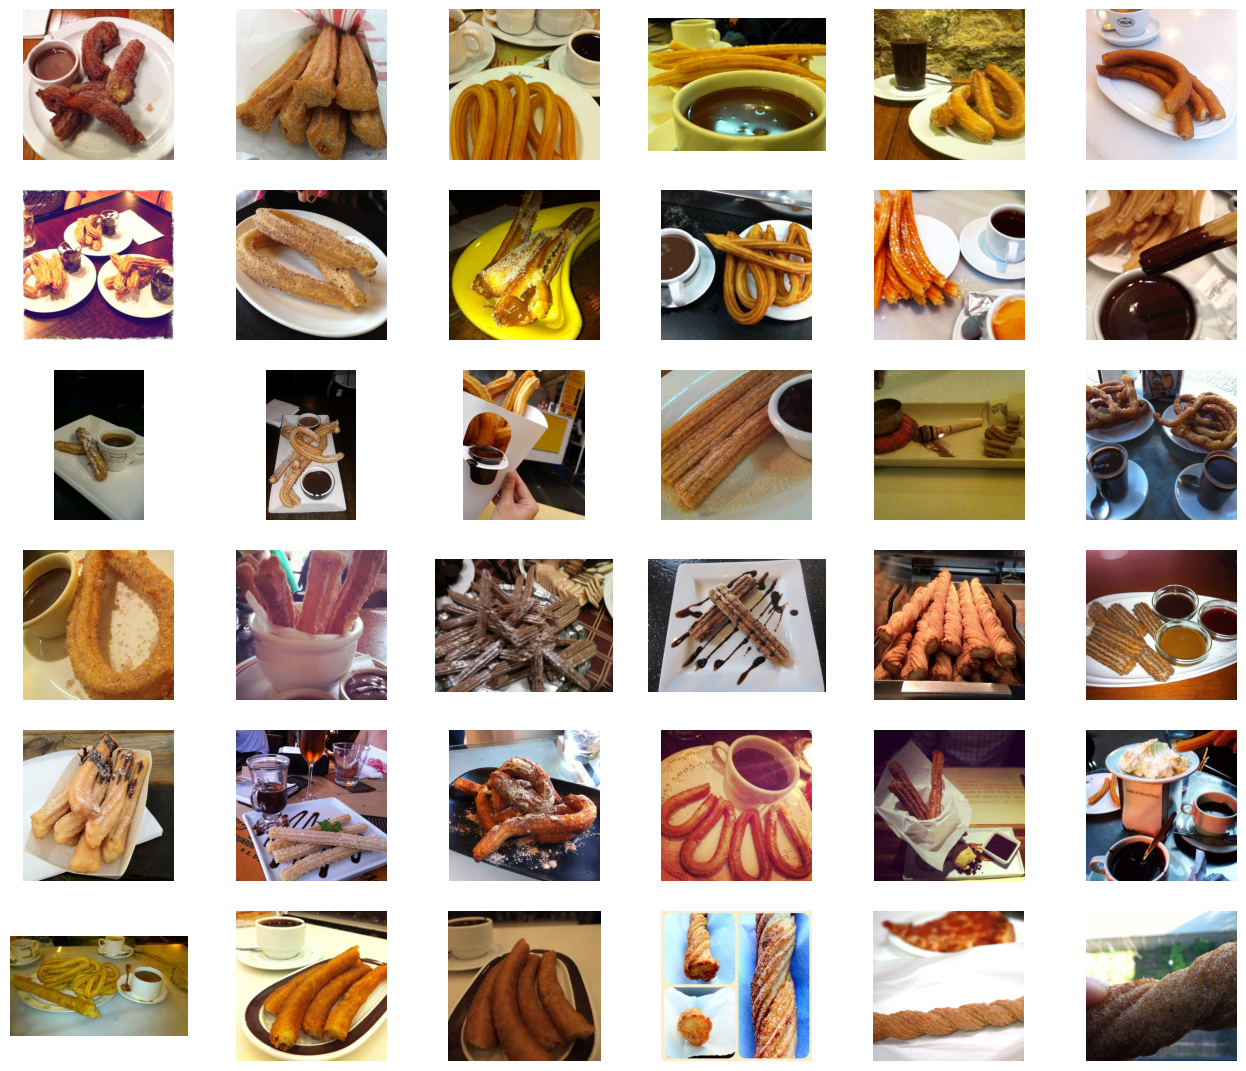

In [2]:
def show_images(dataset, num_samples=36, cols=6):
    rows = num_samples//cols + 1

    plt.figure(figsize=(16, 16))
    for i in range(num_samples):
        image, target = dataset[i]
        image = image.permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

dataset = torchvision.datasets.Food101('./data', transform=torchvision.transforms.ToTensor(), download=True)
show_images(dataset)

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 128

In [4]:
def load_transformed_dataset():
    data_transforms = [
        torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),                  # [ 0, 1]
        torchvision.transforms.Lambda(lambda t: t*2 - 1)    # [-1, 1]  
    ]

    data_transform = torchvision.transforms.Compose(data_transforms)

    train = torchvision.datasets.Food101('./data', download=True, transform=data_transform, split='train')
    test = torchvision.datasets.Food101('./data', download=True, transform=data_transform, split='test')

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(images):
    reverse_transforms = [
        torchvision.transforms.Lambda(lambda t: (t+1) / 2), # [0, 1]
        torchvision.transforms.ToPILImage()
    ]

    reverse_transform = torchvision.transforms.Compose(reverse_transforms)

    image = images[0, :, :, :] if len(images.shape) > 3 else images[:, :, :]

    image = reverse_transform(image)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [5]:
dataset = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)
dataloader

### **Diffusion Closed Form**

In [6]:
def beta_schedule(time_steps, start=0.0001, end=0.02):
    return torch.linspace(start, end, time_steps)

T = 1000

betas = beta_schedule(T)
betas_cumprod = torch.cumprod(betas, 0)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)

sqrt_alphas = torch.sqrt(alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

sqrt_betas = torch.sqrt(betas)
sqrt_betas_cumprod = torch.sqrt(betas_cumprod)

one_minus_alphas_cumprod = 1. - alphas_cumprod
one_minus_betas_cumprod = 1. - betas_cumprod

sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod)
sqrt_one_minus_betas_cumprod = torch.sqrt(one_minus_betas_cumprod)

variance = torch.zeros(T)
variance[1:] = betas[1:] * one_minus_alphas_cumprod[:-1] / one_minus_alphas_cumprod[1:]